## 1. QAOA

Name: Sai Krishna Teja Varma Manthena  
Unity ID: smanthe

<h1 style="font-size:35px;
        color:black;
        ">QAOA Lab for MinCut Problem with Qiskit Runtime</h1>

Prerequisite
- [Ch.4.1.3 QAOA](https://qiskit.org/textbook/ch-applications/qaoa.html)
- [Qiskit Runtime QAOA](https://qiskit.org/documentation/optimization/tutorials/12_qaoa_runtime.html)

In [5]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.quantum_info import Operator, Statevector
from qiskit.tools.monitor import job_monitor
# from qiskit.ignis.mitigation.measurement import *

import numpy as np
import matplotlib.pyplot as plt

## 1. Triangle

<h2 style="font-size:24px;">Part 1: Input</h2>

<br>
<div style="background: #E8E7EB; border-radius: 5px;
-moz-border-radius: 5px;">
  <p style="background: #800080;
            border-radius: 5px 5px 0px 0px;
            padding: 10px 0px 10px 10px;
            font-size:18px;
            color:white;
            "><b>Goal</b></p>
    <p style=" padding: 0px 0px 10px 10px;
              font-size:16px;">Construct the graph of a MinCut input given as a adjacency matrix and print the graph.</p>
</div>

<h3 style="font-size: 20px">1. Read in the matrix. </h3>

In [82]:
# ask for user input to read in one of the files
in_file = input("Enter file name: ")

Enter file name: triangle.in.txt


In [83]:
a_m = []
with open(in_file) as f:
   for line in f:
    a_m += [np.fromstring(line, dtype=int, sep=' ')]

#     res = [eval(i) for i in res]
#     a_m += [res]
a_m = np.array(a_m)
# print(a_m)
nodes = [i for i in range(0,len(a_m))]
edges = []
for i in range(len(a_m)):
    for j in range(i + 1, len(a_m)):
        if a_m[i][j] == 1:
            edges.append((i,j))
nodes, edges

([0, 1, 2], [(0, 1), (0, 2), (1, 2)])

<h3 style="font-size: 20px">2. Print the graph. </h3>

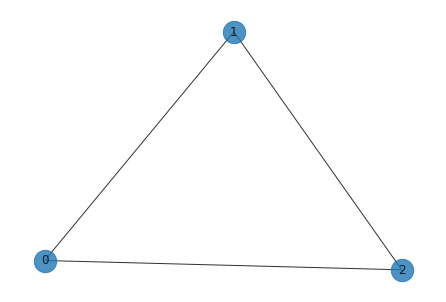

In [84]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

<h3 style="font-size: 20px">3. Create the mixer unitary. </h3>

C:\Users\tejav\AppData\Local\Temp\ipykernel_71012\3794858482.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()


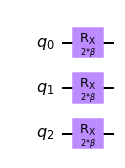

In [85]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = len(nodes)

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw(output="mpl")

<h3 style="font-size: 20px">3. Create the problem unitary. </h3>

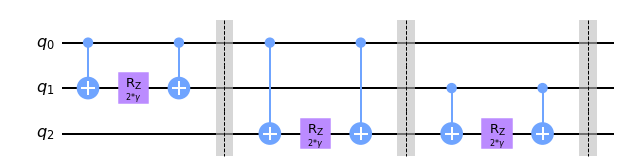

In [86]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for i in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, i[0], i[1])
    qc_p.barrier()
    
qc_p.decompose().draw(output="mpl")

<h3 style="font-size: 20px">4. Create the initial state. </h3>

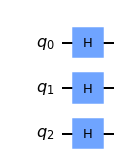

In [87]:
qc_0 = QuantumCircuit(nqubits)
qc_0.h(range(nqubits))
    
qc_0.draw(output="mpl")

<h3 style="font-size: 20px">5. Create the QAOA circuit. </h3>

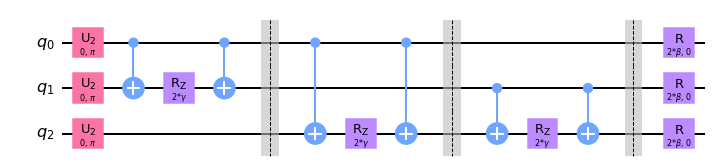

In [88]:
qc_qaoa = QuantumCircuit(nqubits)
qc_qaoa.append(qc_0, range(nqubits))
qc_qaoa.append(qc_p, range(nqubits))
qc_qaoa.append(qc_mix, range(nqubits))
qc_qaoa.decompose().decompose().draw(output="mpl")

<h3 style="font-size: 20px">6. Create the helper functions for the loop. </h3>

In [89]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ


<h3 style="font-size: 20px">6. Create the helper functions for the loop. </h3>

In [90]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=1)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')
res

     fun: -2.0
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 28
  status: 1
 success: True
       x: array([2.82950679, 0.30583342])

<h3 style="font-size: 20px">8. Analyze the results. </h3>

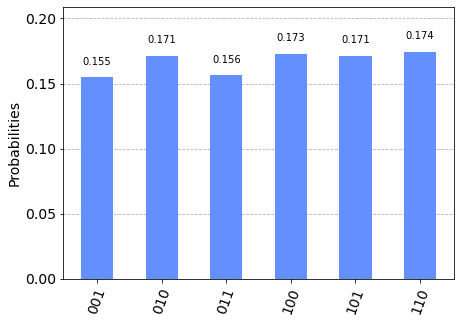

In [91]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

<h3 style="font-size: 20px">9. Repeat with Qiskit.runtime, where the operator is defined as an I/Z matrix, and print the output values and probabilities. </h3>

In [92]:
#generating cost operator
from qiskit.quantum_info import Pauli
from qiskit.opflow import PauliSumOp

def get_operator(adj_matrix):
    numOfnodes = len(adj_matrix)
    pauli_list = []

    for i in range(numOfnodes):
        for j in range(i):
            if adj_matrix[i, j] != 0:
                x_p, z_p = np.zeros(numOfnodes, dtype=bool), np.zeros(numOfnodes, dtype=bool)
                z_p[i],z_p[j] = True,True
                pauli_list.append([-0.5, Pauli((z_p, x_p))])

    for i in range(numOfnodes):
        for j in range(numOfnodes):
            if i != j:
                x_p, z_p = np.zeros(numOfnodes, dtype=bool), np.zeros(numOfnodes, dtype=bool)
                z_p[i],z_p[j] = True,True
                pauli_list.append([1, Pauli((z_p, x_p))])

    pauli_list = [(pauli[1].to_label(), pauli[0]) for pauli in pauli_list]
    return PauliSumOp.from_list(pauli_list)

In [93]:
#pip install qiskit-optimization
from qiskit import IBMQ

IBMQ.load_account()

provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")

program_id = "qaoa"
qaoa_program = provider.runtime.program(program_id)

#print(f"Program name: {qaoa_program.name}, Program id: {qaoa_program.program_id}")
#print(qaoa_program.parameters())


import numpy as np

from qiskit.tools import job_monitor
from qiskit.opflow import PauliSumOp, Z, I
from qiskit.algorithms.optimizers import SPSA

op = get_operator(a_m)

# SPSA helps deal with noisy environments.
optimizer = SPSA(maxiter=100)

# We will run a depth two QAOA.
reps = 9 #TODO: vary this!!

# The initial point for the optimization, chosen at random.
initial_point = np.random.random(2 * reps)

# The backend that will run the programm.
options = {"backend_name": "ibmq_qasm_simulator"}

# The inputs of the program as described above.
runtime_inputs = {
    "operator": op,
    "reps": reps,
    "optimizer": optimizer,
    "initial_point": initial_point,
    "shots": 2**13,
    # Set to True when running on real backends to reduce circuit
    # depth by leveraging swap strategies. If False the
    # given optimization_level (default is 1) will be used.
    "use_swap_strategies": False,
    # Set to True when optimizing sparse problems.
    "use_initial_mapping": False,
    # Set to true when using echoed-cross-resonance hardware.
    "use_pulse_efficient": False,
}

#Now, we run the program using the provider.

job = provider.runtime.run(
    program_id=program_id,
    options=options,
    inputs=runtime_inputs,
)

job_monitor(job)

#Job Status: job has successfully run

print(f"Job id: {job.job_id()}")
print(f"Job status: {job.status()}")

result = job.result()

d=result["eigenstate"]
for w in sorted(d, key=d.get, reverse=True):
    print(w, d[w])


ibmqfactory.load_account:WARNING:2022-11-16 22:32:42,249: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run
Job id: cdqqmnuo2f3r3onjf170
Job status: JobStatus.DONE
101 0.40368783383636914
001 0.39621007290956145
010 0.39404750665370286
100 0.3932722796454131
011 0.3924955214712647
110 0.3921843874378479
000 0.17780947932407878
111 0.17504184767506312


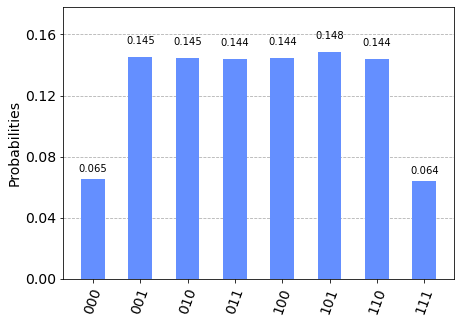

In [94]:
plot_histogram(d)

## 2. SQUARE

<h3 style="font-size: 20px">1. Read in the matrix. </h3>

In [108]:
# ask for user input to read in one of the files
in_file = input("Enter file name: ")

Enter file name: square.in.txt


In [109]:
a_m = []
with open(in_file) as f:
   for line in f:
    a_m += [np.fromstring(line, dtype=int, sep=' ')]

#     res = [eval(i) for i in res]
#     a_m += [res]
a_m = np.array(a_m)
# print(a_m)
nodes = [i for i in range(0,len(a_m))]
edges = []
for i in range(len(a_m)):
    for j in range(i + 1, len(a_m)):
        if a_m[i][j] == 1:
            edges.append((i,j))
nodes, edges

([0, 1, 2, 3], [(0, 1), (0, 3), (1, 2), (2, 3)])

<h3 style="font-size: 20px">2. Print the graph. </h3>

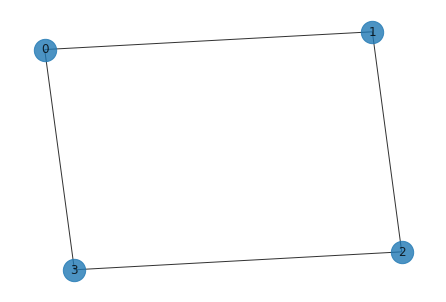

In [110]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

<h3 style="font-size: 20px">3. Create the mixer unitary. </h3>

C:\Users\tejav\AppData\Local\Temp\ipykernel_71012\3794858482.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()


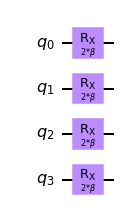

In [111]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = len(nodes)

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw(output="mpl")

<h3 style="font-size: 20px">3. Create the problem unitary. </h3>

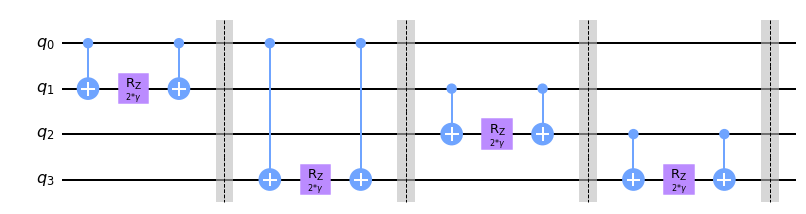

In [112]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for i in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, i[0], i[1])
    qc_p.barrier()
    
qc_p.decompose().draw(output="mpl")

<h3 style="font-size: 20px">4. Create the initial state. </h3>

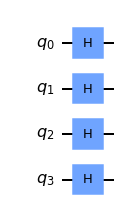

In [113]:
qc_0 = QuantumCircuit(nqubits)
qc_0.h(range(nqubits))
    
qc_0.draw(output="mpl")

<h3 style="font-size: 20px">5. Create the QAOA circuit. </h3>

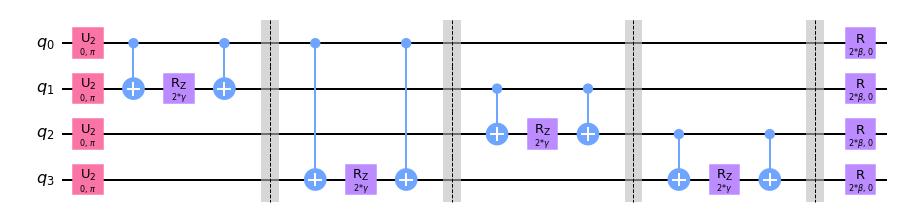

In [114]:
qc_qaoa = QuantumCircuit(nqubits)
qc_qaoa.append(qc_0, range(nqubits))
qc_qaoa.append(qc_p, range(nqubits))
qc_qaoa.append(qc_mix, range(nqubits))
qc_qaoa.decompose().decompose().draw(output="mpl")

<h3 style="font-size: 20px">6. Create the helper functions for the loop. </h3>

In [115]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ


<h3 style="font-size: 20px">6. Create the helper functions for the loop. </h3>

In [116]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=1)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')
res

     fun: -2.994140625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([1.9793337 , 1.16663483])

<h3 style="font-size: 20px">8. Analyze the results. </h3>

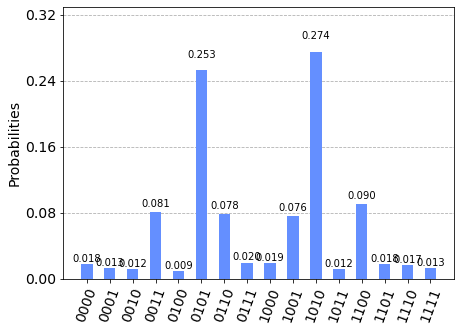

In [117]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

<h3 style="font-size: 20px">9. Repeat with Qiskit.runtime, where the operator is defined as an I/Z matrix, and print the output values and probabilities. </h3>

In [118]:
#generating cost operator
from qiskit.quantum_info import Pauli
from qiskit.opflow import PauliSumOp

def get_operator(adj_matrix):
    numOfnodes = len(adj_matrix)
    pauli_list = []

    for i in range(numOfnodes):
        for j in range(i):
            if adj_matrix[i, j] != 0:
                x_p, z_p = np.zeros(numOfnodes, dtype=bool), np.zeros(numOfnodes, dtype=bool)
                z_p[i],z_p[j] = True,True
                pauli_list.append([-0.5, Pauli((z_p, x_p))])

    for i in range(numOfnodes):
        for j in range(numOfnodes):
            if i != j:
                x_p, z_p = np.zeros(numOfnodes, dtype=bool), np.zeros(numOfnodes, dtype=bool)
                z_p[i],z_p[j] = True,True
                pauli_list.append([1, Pauli((z_p, x_p))])

    pauli_list = [(pauli[1].to_label(), pauli[0]) for pauli in pauli_list]
    return PauliSumOp.from_list(pauli_list)

In [119]:
#pip install qiskit-optimization
from qiskit import IBMQ

IBMQ.load_account()

provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")

program_id = "qaoa"
qaoa_program = provider.runtime.program(program_id)

#print(f"Program name: {qaoa_program.name}, Program id: {qaoa_program.program_id}")
#print(qaoa_program.parameters())


import numpy as np

from qiskit.tools import job_monitor
from qiskit.opflow import PauliSumOp, Z, I
from qiskit.algorithms.optimizers import SPSA

op = get_operator(a_m)

# SPSA helps deal with noisy environments.
optimizer = SPSA(maxiter=100)

# We will run a depth two QAOA.
reps = 9 #TODO: vary this!!

# The initial point for the optimization, chosen at random.
initial_point = np.random.random(2 * reps)

# The backend that will run the programm.
options = {"backend_name": "ibmq_qasm_simulator"}

# The inputs of the program as described above.
runtime_inputs = {
    "operator": op,
    "reps": reps,
    "optimizer": optimizer,
    "initial_point": initial_point,
    "shots": 2**13,
    # Set to True when running on real backends to reduce circuit
    # depth by leveraging swap strategies. If False the
    # given optimization_level (default is 1) will be used.
    "use_swap_strategies": False,
    # Set to True when optimizing sparse problems.
    "use_initial_mapping": False,
    # Set to true when using echoed-cross-resonance hardware.
    "use_pulse_efficient": False,
}

#Now, we run the program using the provider.

job = provider.runtime.run(
    program_id=program_id,
    options=options,
    inputs=runtime_inputs,
)

job_monitor(job)

#Job Status: job has successfully run

print(f"Job id: {job.job_id()}")
print(f"Job status: {job.status()}")

result = job.result()

d=result["eigenstate"]
for w in sorted(d, key=d.get, reverse=True):
    print(w, d[w])


ibmqfactory.load_account:WARNING:2022-11-16 22:35:27,650: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run
Job id: cdqqo12ojhkj8peukr60
Job status: JobStatus.DONE
1111 0.43736046882120017
0000 0.43399826288534843
1010 0.3173452501810922
0101 0.31618916163825095
0011 0.23463527215126886
1001 0.22963966338592295
0110 0.22642776165920997
1100 0.225888004606265
1011 0.16828640022295324
1000 0.16424840657522374
0010 0.16387638252658618
0100 0.16312978920172735
0111 0.1608692209529219
1101 0.16010860571811872
1110 0.15819106821341083
0001 0.15585888549421878


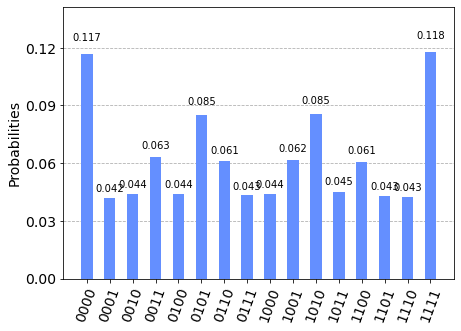

In [120]:
plot_histogram(d)

## 3. Hexagon

<h3 style="font-size: 20px">1. Read in the matrix. </h3>

In [122]:
# ask for user input to read in one of the files
in_file = input("Enter file name: ")

Enter file name: hexagon.in.txt


In [123]:
a_m = []
with open(in_file) as f:
   for line in f:
    a_m += [np.fromstring(line, dtype=int, sep=' ')]

#     res = [eval(i) for i in res]
#     a_m += [res]
a_m = np.array(a_m)
# print(a_m)
nodes = [i for i in range(0,len(a_m))]
edges = []
for i in range(len(a_m)):
    for j in range(i + 1, len(a_m)):
        if a_m[i][j] == 1:
            edges.append((i,j))
nodes, edges

([0, 1, 2, 3, 4, 5], [(0, 1), (0, 5), (1, 2), (2, 3), (3, 4), (4, 5)])

<h3 style="font-size: 20px">2. Print the graph. </h3>

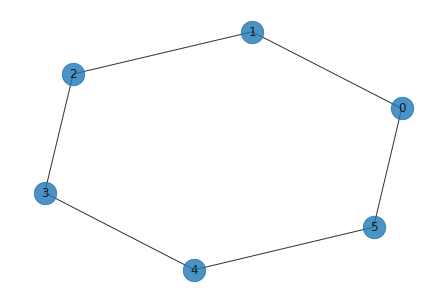

In [124]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

<h3 style="font-size: 20px">3. Create the mixer unitary. </h3>

C:\Users\tejav\AppData\Local\Temp\ipykernel_71012\3794858482.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()


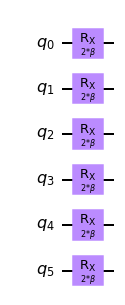

In [125]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = len(nodes)

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw(output="mpl")

<h3 style="font-size: 20px">3. Create the problem unitary. </h3>

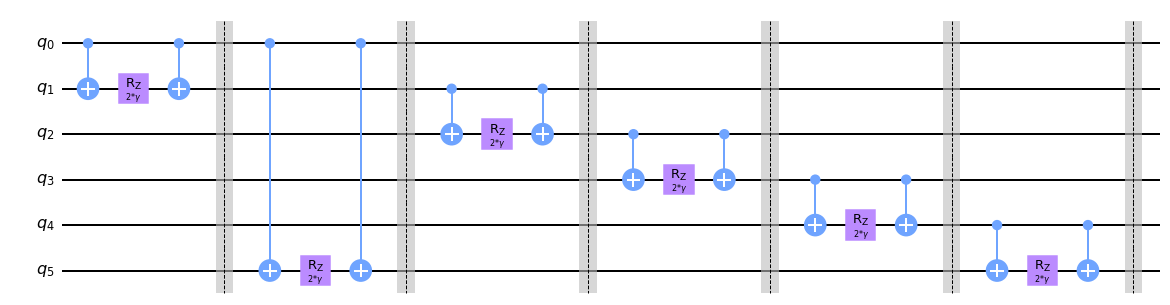

In [126]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for i in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, i[0], i[1])
    qc_p.barrier()
    
qc_p.decompose().draw(output="mpl")

<h3 style="font-size: 20px">4. Create the initial state. </h3>

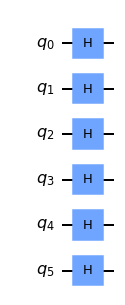

In [127]:
qc_0 = QuantumCircuit(nqubits)
qc_0.h(range(nqubits))
    
qc_0.draw(output="mpl")

<h3 style="font-size: 20px">5. Create the QAOA circuit. </h3>

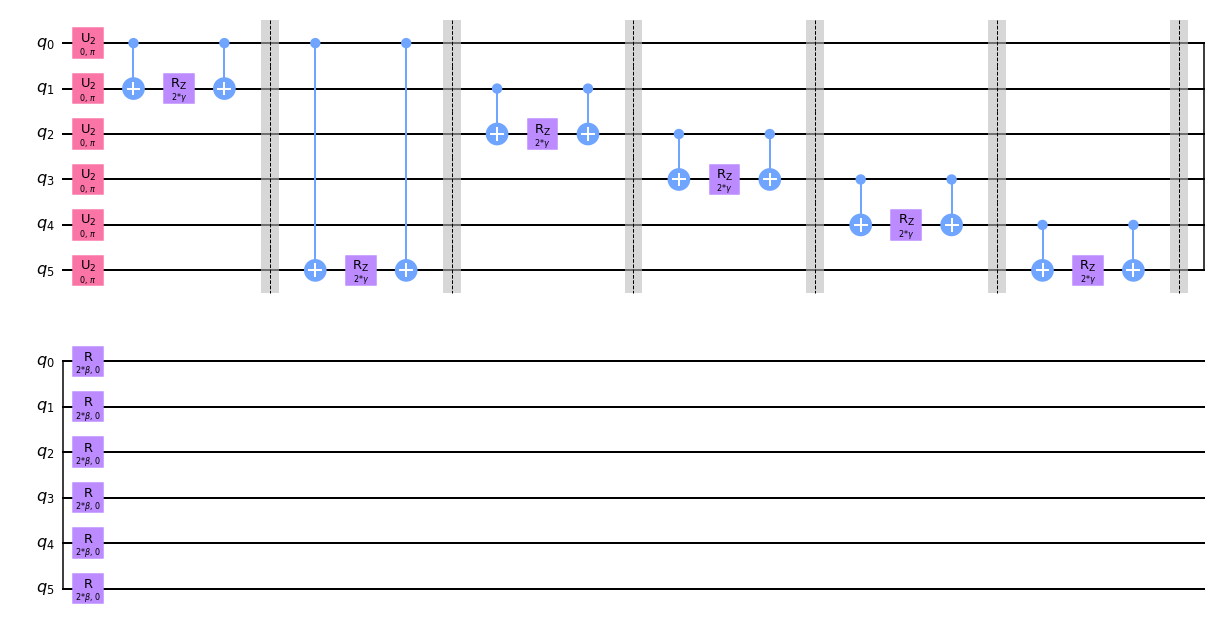

In [128]:
qc_qaoa = QuantumCircuit(nqubits)
qc_qaoa.append(qc_0, range(nqubits))
qc_qaoa.append(qc_p, range(nqubits))
qc_qaoa.append(qc_mix, range(nqubits))
qc_qaoa.decompose().decompose().draw(output="mpl")

<h3 style="font-size: 20px">6. Create the helper functions for the loop. </h3>

In [129]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ


<h3 style="font-size: 20px">6. Create the helper functions for the loop. </h3>

In [130]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=1)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')
res

     fun: -4.544921875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 27
  status: 1
 success: True
       x: array([1.96466702, 1.19343162])

<h3 style="font-size: 20px">8. Analyze the results. </h3>

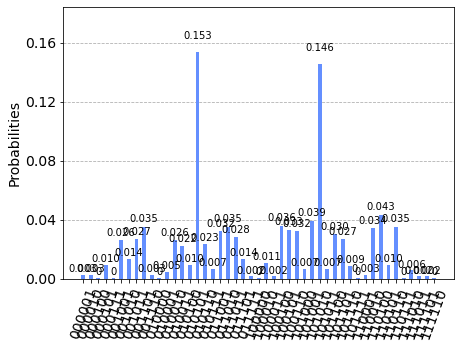

In [131]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

<h3 style="font-size: 20px">9. Repeat with Qiskit.runtime, where the operator is defined as an I/Z matrix, and print the output values and probabilities. </h3>

In [132]:
#generating cost operator
from qiskit.quantum_info import Pauli
from qiskit.opflow import PauliSumOp

def get_operator(adj_matrix):
    numOfnodes = len(adj_matrix)
    pauli_list = []

    for i in range(numOfnodes):
        for j in range(i):
            if adj_matrix[i, j] != 0:
                x_p, z_p = np.zeros(numOfnodes, dtype=bool), np.zeros(numOfnodes, dtype=bool)
                z_p[i],z_p[j] = True,True
                pauli_list.append([-0.5, Pauli((z_p, x_p))])

    for i in range(numOfnodes):
        for j in range(numOfnodes):
            if i != j:
                x_p, z_p = np.zeros(numOfnodes, dtype=bool), np.zeros(numOfnodes, dtype=bool)
                z_p[i],z_p[j] = True,True
                pauli_list.append([1, Pauli((z_p, x_p))])

    pauli_list = [(pauli[1].to_label(), pauli[0]) for pauli in pauli_list]
    return PauliSumOp.from_list(pauli_list)

In [133]:
#pip install qiskit-optimization
from qiskit import IBMQ

IBMQ.load_account()

provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")

program_id = "qaoa"
qaoa_program = provider.runtime.program(program_id)

#print(f"Program name: {qaoa_program.name}, Program id: {qaoa_program.program_id}")
#print(qaoa_program.parameters())


import numpy as np

from qiskit.tools import job_monitor
from qiskit.opflow import PauliSumOp, Z, I
from qiskit.algorithms.optimizers import SPSA

op = get_operator(a_m)

# SPSA helps deal with noisy environments.
optimizer = SPSA(maxiter=100)

# We will run a depth two QAOA.
reps = 9 #TODO: vary this!!

# The initial point for the optimization, chosen at random.
initial_point = np.random.random(2 * reps)

# The backend that will run the programm.
options = {"backend_name": "ibmq_qasm_simulator"}

# The inputs of the program as described above.
runtime_inputs = {
    "operator": op,
    "reps": reps,
    "optimizer": optimizer,
    "initial_point": initial_point,
    "shots": 2**13,
    # Set to True when running on real backends to reduce circuit
    # depth by leveraging swap strategies. If False the
    # given optimization_level (default is 1) will be used.
    "use_swap_strategies": False,
    # Set to True when optimizing sparse problems.
    "use_initial_mapping": False,
    # Set to true when using echoed-cross-resonance hardware.
    "use_pulse_efficient": False,
}

#Now, we run the program using the provider.

job = provider.runtime.run(
    program_id=program_id,
    options=options,
    inputs=runtime_inputs,
)

job_monitor(job)

#Job Status: job has successfully run

print(f"Job id: {job.job_id()}")
print(f"Job status: {job.status()}")

result = job.result()

d=result["eigenstate"]
for w in sorted(d, key=d.get, reverse=True):
    print(w, d[w])


ibmqfactory.load_account:WARNING:2022-11-16 22:37:13,655: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run
Job id: cdqqord9du1ksnbn1ccg
Job status: JobStatus.DONE
010101 0.30797505225667227
101010 0.3043868709184087
011100 0.273772116686488
001110 0.27332587007087344
111000 0.2699555084870468
110001 0.2635488717723906
000111 0.2626208799058064
100011 0.261689597256941
011011 0.16792332234534904
001001 0.15857643070456592
101101 0.15428451295415233
110110 0.15388840315306412
100100 0.15349127112803515
010010 0.14740595518838442
110111 0.12352647110032731
001000 0.12203515118604147
100000 0.12052537984798056
011111 0.11692679333668567
111110 0.11692679333668567
000100 0.11428702217443588
010000 0.11158481919598204
000010 0.11103648752774918
101111 0.10993161937086163
111011 0.10825317547305482
111111 0.10305395279900718
000001 0.10245997694221876
111101 0.10245997694221876
000000 0.0943987966687076
000011 0.0625
001111 0.05633673867912483
011110 0.05524271728019903
000110 0.05412658773652741
100001 0.05412658773652741
111001 0.05412658773652741
110011 0.05

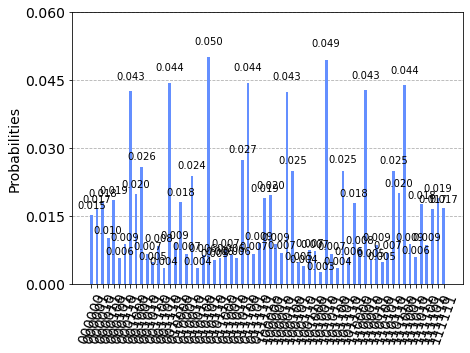

In [134]:
plot_histogram(d)

<h3 style="font-size: 20px">10. Try for different "reps" values. Analyze the results (verbally). </h3>